## Flow
0. Column들의 의미
    - 변수 정의
    - 변수들의 분포 (연속적 / 비연속적)
<br><br>
1. Column별 unique한 값 (시각화)
<br><br>
2. Column과 Price와의 관계 (상관관계)
    - 상관계수가 높은 상위 10개 변수 heatmap
    - 각 변수별 detail, insight
<br><br>
3. Price 자체 분포
    - 분포 형태 파악 및 스케일링(log)
<br><br>
4. 이외의 변수들
    - 시간관련 변수
    - View and Condition (개별분포 이외에 둘의 관계)
    - Zipcode
<br><br>
5. 독립변수들 간의 관계
<br><br>
6. 그외 insight 도출

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import warnings
import seaborn as sns
import random
warnings.filterwarnings('ignore')

### 0. 각 Columns들이 의미하는 것이 무엇인지 숙지하자.
- ID : 집을 구분하는 번호
- date : 집을 구매한 날짜 
- price : 집의 가격(Target variable) 
- bedrooms : 침실의 수
- bathrooms : 침실 개수 당 화장실의 수(화장실의 수 / 침실의 수 )
- sqft_living : 주거 공간의 평방 피트(면적)
- sqft_lot : 부지의 평방 피트(면적) ; *부지면적 = 볼록 튀어나온 가로선을 수평 일직선으로 만든것.
- floors : 집의 층 수
- waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
- view : 집이 얼마나 좋아 보이는지의 정도
- condition : 집의 전반적인 상태
- grade : King County grading 시스템 기준으로 매긴 집의 등급
- sqft_above : 지하실을 제외한 평방 피트(면적)
- sqft_basement : 지하실의 평방 피트(면적)
- yr_built : 지어진 년도
- yr_renovated : 집을 재건축한 년도
- zipcode : 우편번호 
- lat : 위도
- long : 경도
- sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
- sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음) --> 조금 이슈가 있음
    - sqft_living15, sqft_lot15는 15년도 기준 측정면적이라는 의견과 해당거주지 주변 이웃 15곳의 평균치라는 의견이 있음.

In [2]:
train = pd.read_csv("../dataset/train.csv")
train.tail()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15030,15030,20141014T000000,610685.0,4,2.50,2520,6023,2.0,0,0,...,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,15031,20150326T000000,1007500.0,4,3.50,3510,7200,2.0,0,0,...,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,15032,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,15033,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
15034,15034,20141015T000000,325000.0,2,0.75,1020,1076,2.0,0,0,...,7,1020,0,2008,0,98144,47.5941,-122.299,1020,1357


- date의 T이전까지만 잘라서 year, month, day 표기해볼 수 있을거 같다.
- bathroom의 경우, .5의 의미는 "**where .5 accounts for a room with a toilet but no shower**" 샤워실없이 화장실만...

In [3]:
test = pd.read_csv("../dataset/test.csv")
test.tail()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
6463,21498,20140626T000000,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
6464,21499,20150126T000000,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
6465,21500,20150219T000000,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
6466,21501,20140623T000000,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
6467,21502,20150116T000000,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [4]:
train.info()
cols = []
for col in train.columns[1:]:
    if train[col].dtype == 'object':
        cols.append(col)
print("object data type을 가진 columns : ",cols)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
id               15035 non-null int64
date             15035 non-null object
price            15035 non-null float64
bedrooms         15035 non-null int64
bathrooms        15035 non-null float64
sqft_living      15035 non-null int64
sqft_lot         15035 non-null int64
floors           15035 non-null float64
waterfront       15035 non-null int64
view             15035 non-null int64
condition        15035 non-null int64
grade            15035 non-null int64
sqft_above       15035 non-null int64
sqft_basement    15035 non-null int64
yr_built         15035 non-null int64
yr_renovated     15035 non-null int64
zipcode          15035 non-null int64
lat              15035 non-null float64
long             15035 non-null float64
sqft_living15    15035 non-null int64
sqft_lot15       15035 non-null int64
dtypes: float64(5), int64(15), object(1)
memory usage: 2.4+ MB
object data type을 가

- 일단 전체적으로 null값이 없고
- dtype도 date를 제외하고는 수치화되어있다.

In [5]:
df_train = train[[column for column in train.columns if column != cols[0] and column != 'id']]
df_train.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,1.503500e+04,15035.000000,15035.000000,15035.000000,1.503500e+04,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000
mean,5.406827e+05,3.369139,2.115065,2083.790223,1.529697e+04,1.498071,0.007117,0.234253,3.406651,7.660725,1794.158164,289.632059,1971.100432,83.798936,98078.031726,47.560721,-122.213677,1992.754772,12823.884935
std,3.715247e+05,0.902721,0.767519,922.134087,4.261282e+04,0.538522,0.084063,0.763376,0.646505,1.179803,831.738609,440.663284,29.407612,400.398498,53.297815,0.138164,0.141294,691.456442,27736.259787
min,7.800000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.027500e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.472700,-122.328000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.620000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1570.000000,0.000000,1975.000000,0.000000,98065.000000,47.571900,-122.231000,1850.000000,7610.000000
75%,6.450000e+05,4.000000,2.500000,2560.000000,1.069550e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2230.000000,550.000000,1997.000000,0.000000,98117.000000,47.678300,-122.126000,2360.000000,10076.000000
max,7.700000e+06,10.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4130.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


- 독립변수
    - 연속형 변수 : ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15', 'sqft_lot15']
    - 비연속형 변수 : ['bedrooms', 'bathrooms', 'floors','waterfront', 'view', 'condition', 'grade', 'yr_built', 'yr_renovated', 'zipcode']
- 목적변수(target)
    - ['price']

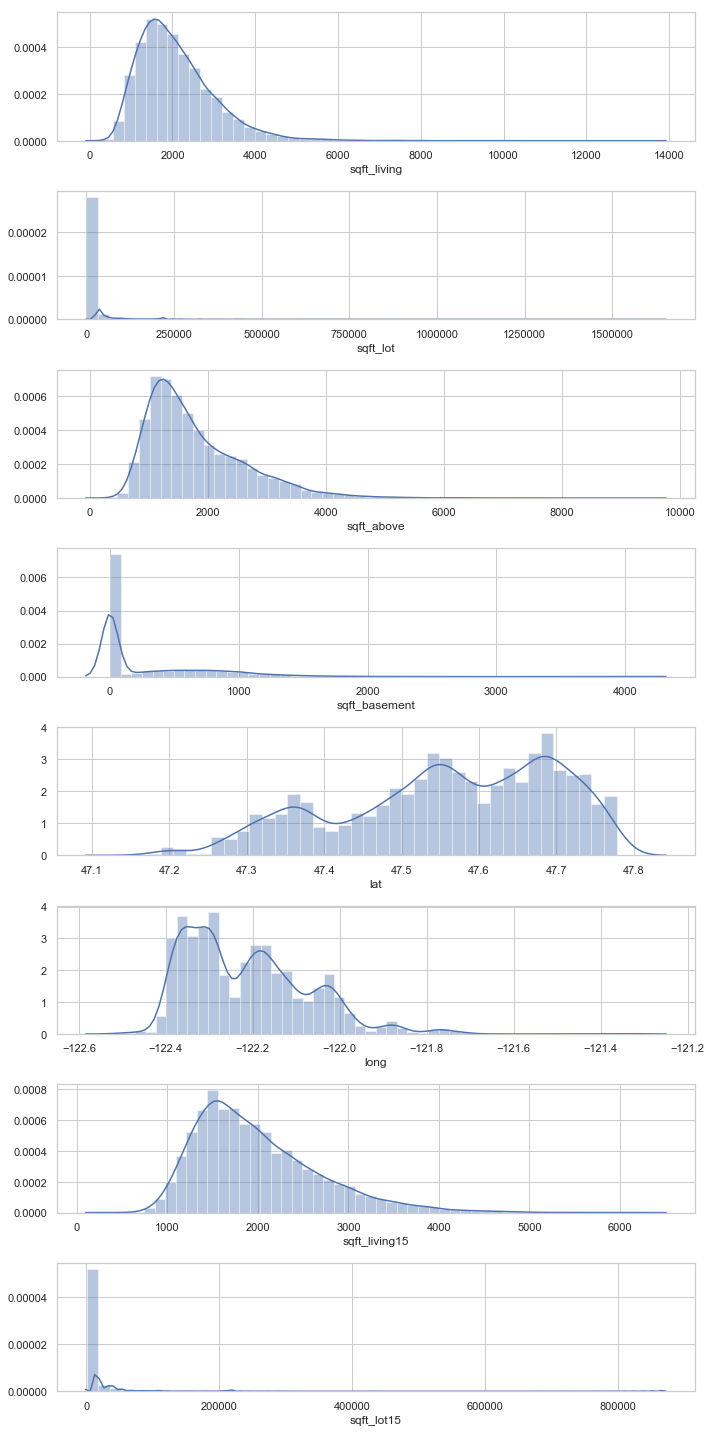

In [6]:
# 연속형 변수의 분포
continuous = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15', 'sqft_lot15']
plt.figure(figsize=(10,20))
count = 1
for col in continuous:
    plt.subplot(len(continuous), 1, count)
    # plt.title(col)
    sns.distplot(df_train[col])
    count += 1
plt.tight_layout()

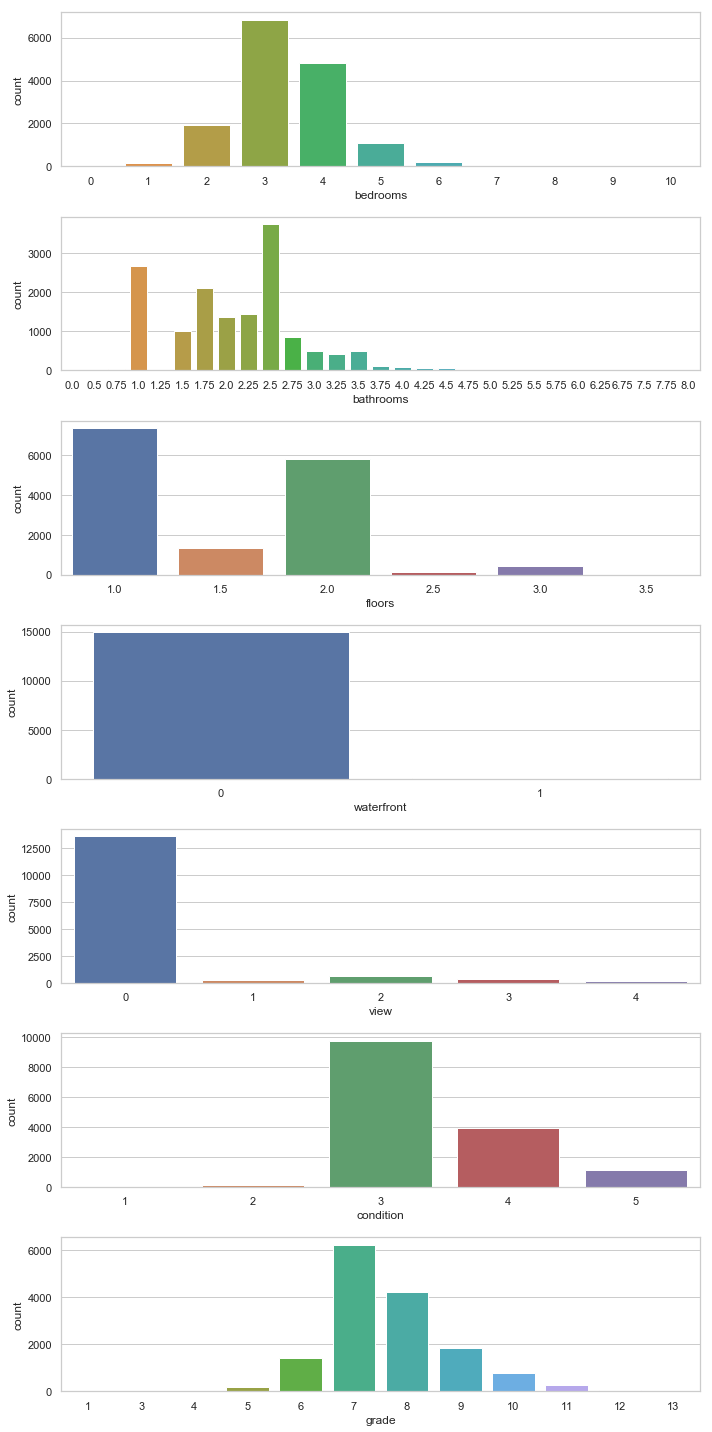

In [7]:
# 비연속형 변수의 빈도분포
# yr_built, yr_renovated, zipcode는 제외
non_continuous = ['bedrooms', 'bathrooms', 'floors','waterfront', 'view', 'condition', 'grade']
plt.figure(figsize=(10,20))
count = 1
for col in non_continuous:
    plt.subplot(len(non_continuous), 1, count)
    # plt.title(col)
    sns.countplot(x=col,data=df_train)
    count += 1
plt.tight_layout()

In [8]:
df_train.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,1.503500e+04,15035.000000,15035.000000,15035.000000,1.503500e+04,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000
mean,5.406827e+05,3.369139,2.115065,2083.790223,1.529697e+04,1.498071,0.007117,0.234253,3.406651,7.660725,1794.158164,289.632059,1971.100432,83.798936,98078.031726,47.560721,-122.213677,1992.754772,12823.884935
std,3.715247e+05,0.902721,0.767519,922.134087,4.261282e+04,0.538522,0.084063,0.763376,0.646505,1.179803,831.738609,440.663284,29.407612,400.398498,53.297815,0.138164,0.141294,691.456442,27736.259787
min,7.800000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.027500e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.472700,-122.328000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.620000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1570.000000,0.000000,1975.000000,0.000000,98065.000000,47.571900,-122.231000,1850.000000,7610.000000
75%,6.450000e+05,4.000000,2.500000,2560.000000,1.069550e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2230.000000,550.000000,1997.000000,0.000000,98117.000000,47.678300,-122.126000,2360.000000,10076.000000
max,7.700000e+06,10.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4130.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [9]:
df_train[df_train.sqft_living == 13540.000000]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,2280000.0,7,8.0,13540,307752,3.0,0,4,3,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


- 아직 이것이 outlier인지 아닌지 알 수 없다..

---
### 1. Column별로 Unique한 값은 ?!

In [10]:
df_train.tail()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15030,610685.0,4,2.50,2520,6023,2.0,0,0,3,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,1007500.0,4,3.50,3510,7200,2.0,0,0,3,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
15034,325000.0,2,0.75,1020,1076,2.0,0,0,3,7,1020,0,2008,0,98144,47.5941,-122.299,1020,1357


In [11]:
for col in df_train.columns:
    print("column : ", col)
    print("{}의 unique value 갯수 : {}\n".format(col, df_train[col].nunique()))

column :  price
price의 unique value 갯수 : 3263

column :  bedrooms
bedrooms의 unique value 갯수 : 11

column :  bathrooms
bathrooms의 unique value 갯수 : 29

column :  sqft_living
sqft_living의 unique value 갯수 : 863

column :  sqft_lot
sqft_lot의 unique value 갯수 : 7678

column :  floors
floors의 unique value 갯수 : 6

column :  waterfront
waterfront의 unique value 갯수 : 2

column :  view
view의 unique value 갯수 : 5

column :  condition
condition의 unique value 갯수 : 5

column :  grade
grade의 unique value 갯수 : 12

column :  sqft_above
sqft_above의 unique value 갯수 : 789

column :  sqft_basement
sqft_basement의 unique value 갯수 : 271

column :  yr_built
yr_built의 unique value 갯수 : 116

column :  yr_renovated
yr_renovated의 unique value 갯수 : 65

column :  zipcode
zipcode의 unique value 갯수 : 70

column :  lat
lat의 unique value 갯수 : 4692

column :  long
long의 unique value 갯수 : 716

column :  sqft_living15
sqft_living15의 unique value 갯수 : 682

column :  sqft_lot15
sqft_lot15의 unique value 갯수 : 6958



In [12]:
# 결측치 시각화
# 본 코드는 현우님 kernel을 참고하였습니다. (https://www.kaggle.com/chocozzz/house-price-prediction-eda-updated-2019-03-12)
# yr_built, yr_renovated, zipcode는 제외하였다.
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

In [45]:
uniq = dict()
cols = ['bedrooms', 'bathrooms', 'floors','waterfront', 'view', 'condition', 'grade']

for col in cols:
    uniq[col] = len(df_train[col].unique())

def generate_color():
    color = '#{:02x}{:02x}{:02x}'.format(*map(lambda x: random.randint(0, 255), range(3)))
    return color
    
data = [
    go.Bar(
        x = list(uniq.keys()), # ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade']
        y = list(uniq.values()), # [11, 29, 6, 2, 5, 5, 12]
        name = 'Unique value in features',
        textfont=dict(size=20),
        marker=dict(
        line=dict(
            color= generate_color(),
            #width= 2,
        ), opacity = 0.45
    )
    ),
    ]
layout= go.Layout(
        title= "Unique Value By Column",
        xaxis= dict(title='Columns', ticklen=5, zeroline=False, gridwidth=2),
        yaxis= dict(title='Value Count', ticklen=5, gridwidth=2),
        showlegend=True
    )
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='skin')

##### bathrooms 소숫점의 의미
- full bath : 화장실, 세면대, 샤워실, 욕조 ---> 1
- 3/4 bath : 화장실, 세면대, 샤워실 ---> 0.75
- half bath : 화장실, 세면대 ---> 0.5
- [참고 Discussion](https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr/discussion/83533)

- 튀는 값은 딱히 없어보이는데...

---
### 2. Column과 Price와의 관계
- 먼저, 각 column과 price간의 선형관계 맛보기.
- 변수가 많을때, 살펴봐야할 변수를 상관관계의 정도로 우선순위화한다.

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


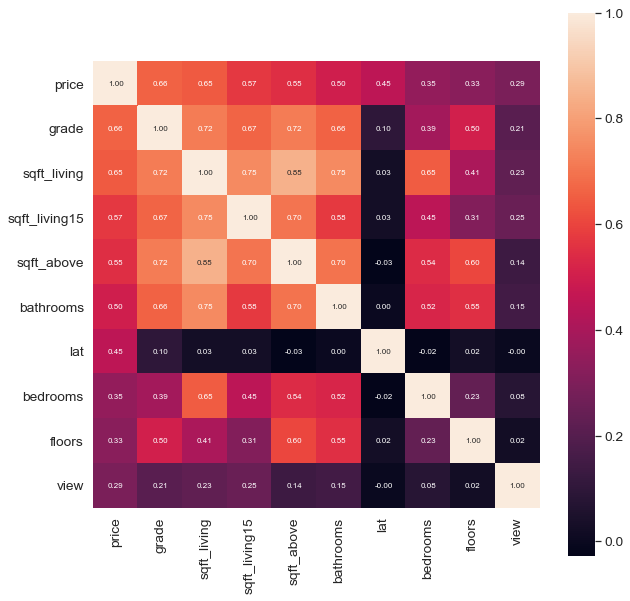

In [18]:
# correlation이 높은 상위 10개의 heatmap
# continuous + sequential variables --> spearman
# abs는 반비례관계도 고려하기 위함
cor_abs = abs(df_train.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=10, columns='price').index # price과 correlation이 높은 column 10개 뽑기(내림차순)
# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(df_train[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

---
##### 2-1. column별로 좀 더 자세하게 보기

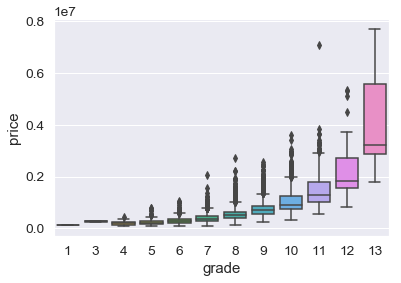

In [19]:
# 가장 높은 grade를 따로 뽑아보자
# grade는 순서의 의미를 가진 변수
# 확률변수값 x price --> boxplot
sns.boxplot(data=df_train, x='grade', y='price')

- 각 box위 아래로 그어진 선의 의미 : 1.5 x IQR 만큼 높은 값의 구간을 기준으로 그 구간의 내부에 있는 가장 큰 데이터와 가장 작은 데이터를 잇는 선분
- grade가 13에 가까울수록 높은 등급이다.
- 이것보다 위에 찍힌 검은점들은 outlier.
- 뭔가 선형적관계가 있는거 같으면서도, exponential한 관계도 있는듯.
- grade = 11에 튀는 값도 보이고

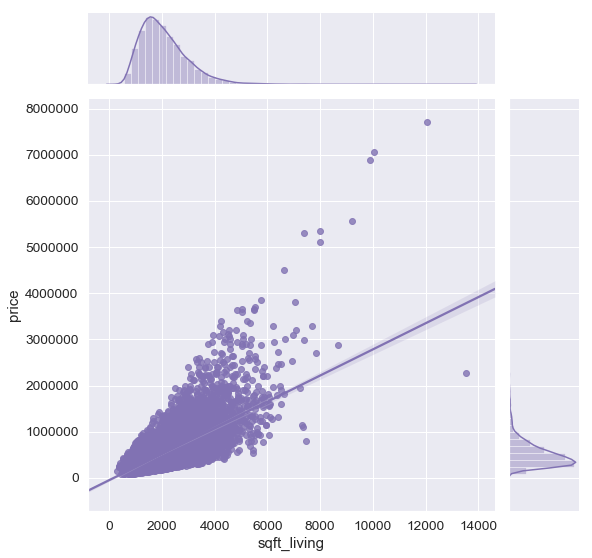

In [20]:
# 다음으로 높은 sqft_living
sns.jointplot(data=df_train, x='sqft_living', y='price',kind="reg", color="m",height=8)
plt.show()

- 주거면적이 14000피트에 이르는데 가격이 2000000정도라는건 튀는값인가..

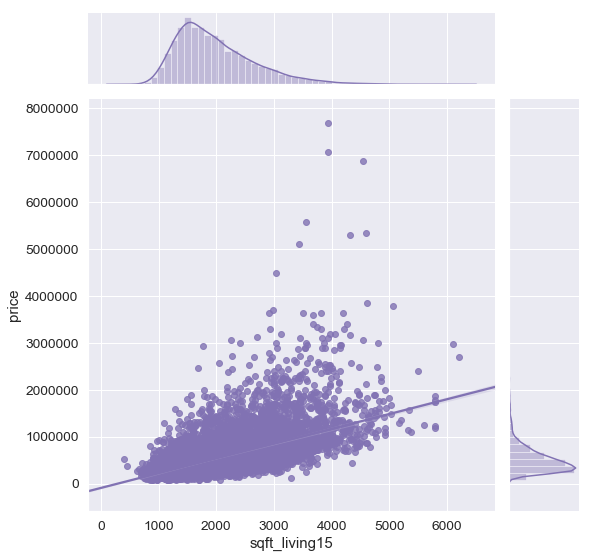

In [21]:
# sqft_living15
sns.jointplot(data=df_train, x='sqft_living15', y='price',kind="reg", color="m",height=8)
plt.show()

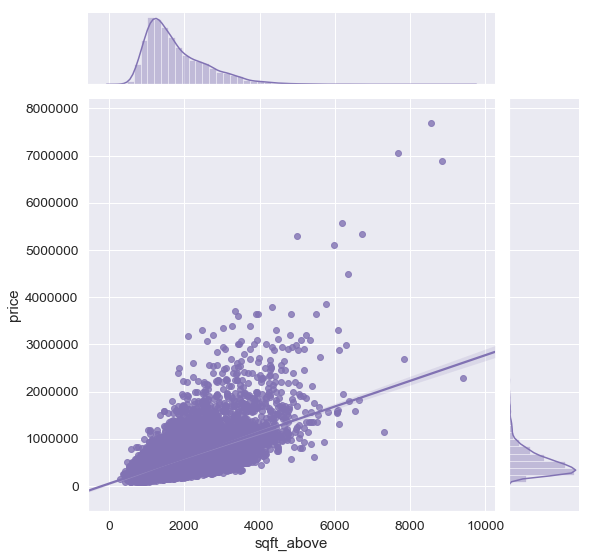

In [22]:
# sqft_above
sns.jointplot(data=df_train, x='sqft_above', y='price',kind="reg", color="m",height=8)
plt.show()

- 위 3개의 features들(sqft_living, sqft_living15, sqft_above) 비슷한 분포를 가진다.
- 0.55, 0.7, 0.75의 상관성을 갖는다.

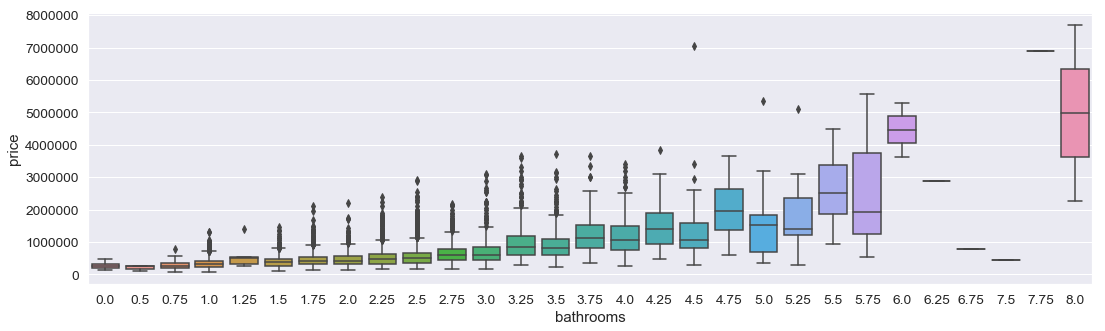

In [23]:
# bathrooms
plt.figure(figsize=(18,5))
sns.boxplot(data=df_train, x='bathrooms', y='price')
plt.show()

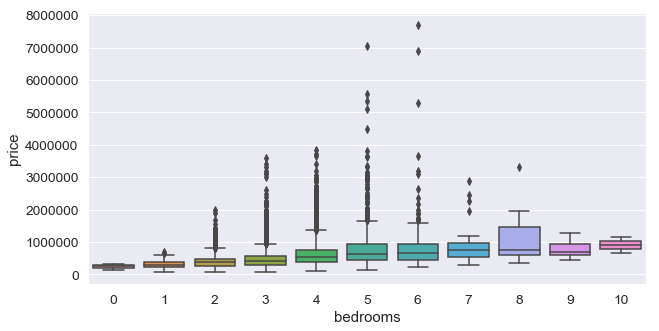

In [24]:
# bedrooms
plt.figure(figsize=(10,5))
sns.boxplot(data=df_train, x='bedrooms', y='price')
plt.show()

- bedrooms 2~6에 이상치(outlier)가 집중되어있다. 왜지?

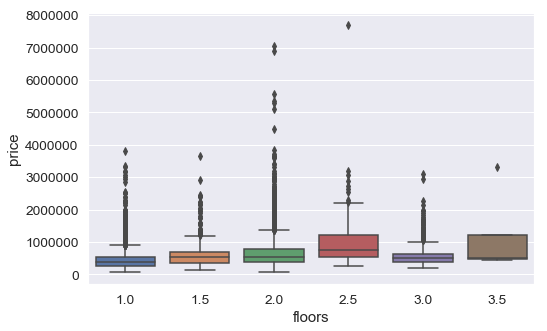

In [25]:
# floors
plt.figure(figsize=(8,5))
sns.boxplot(data=df_train, x='floors', y='price')
plt.show()

- floor가 높을수록 가격이 큰거같진 않다. 뭔가 더 큰 요인이 가격에 영향이 있는 걸로 보인다.

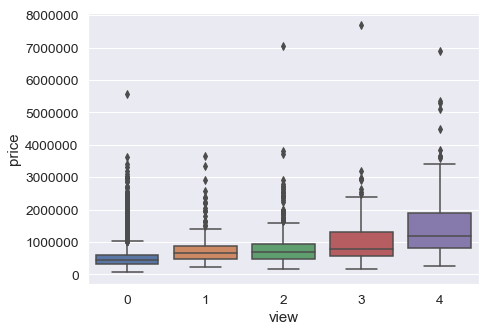

In [26]:
# view
plt.figure(figsize=(7,5))
sns.boxplot(data=df_train, x='view', y='price')
plt.show()

##### **지리적 정보 시각화**

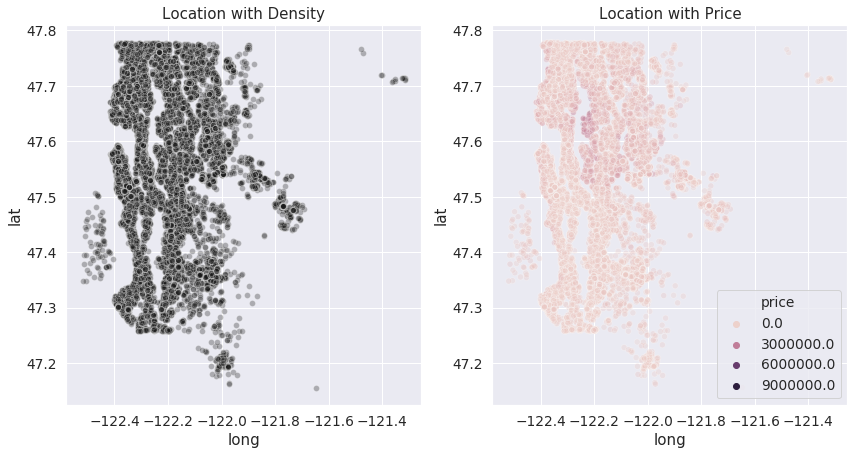

In [24]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.title("Location with Density")
sns.scatterplot(data=df_train, x='long', y='lat', alpha=0.3, color='k')
plt.subplot(1,2,2)
plt.title("Location with Price")
sns.scatterplot(data=df_train, x='long', y='lat', alpha=0.3, color='r', hue='price')

- density가 높으면 가격이 높은지 궁금해서 찍어보았다.
- 그래도 나름.... **가격이 낮은(우측 그림상으로 흐릿한)부분은 density도 대체로 흐릿하다.**

### 3. 'Price' 자체의 분포와  log스케일링
- 원래 선형회귀모형의 가정에는 독립 변수나 종속 변수가 반드시 대칭 분포를 보여야 한다는 가정은 없지만,
- 정규 분포에 가까운 분포를 보일 수록 선형회귀모형의 성능이 좋아지는 경우가 많다.

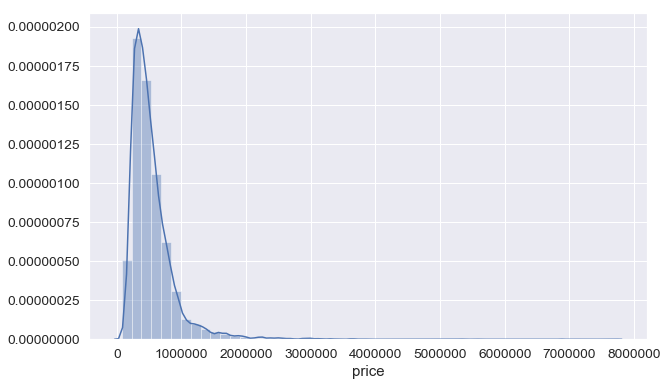

In [27]:
plt.figure(figsize=(10,6))
sns.distplot(df_train['price'])

- 심하게 한쪽으로 치우쳤다.
- 이경우 회귀의 성능에 안좋은 영향을 미칠수 있다.

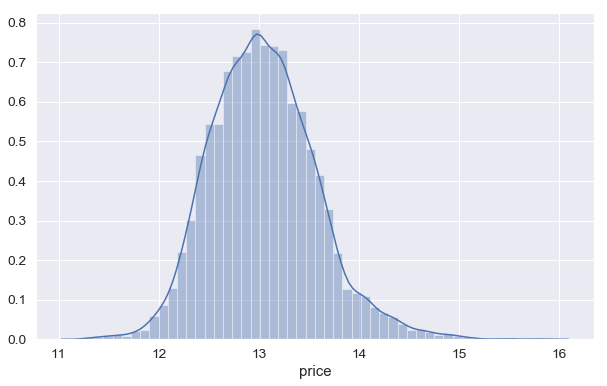

In [28]:
# log를 취하여 다시 그려보자
plt.figure(figsize=(10,6))
sns.distplot(np.log1p(df_train['price']))

- 종속변수가 조금더 대칭분포와 비슷해졌다.

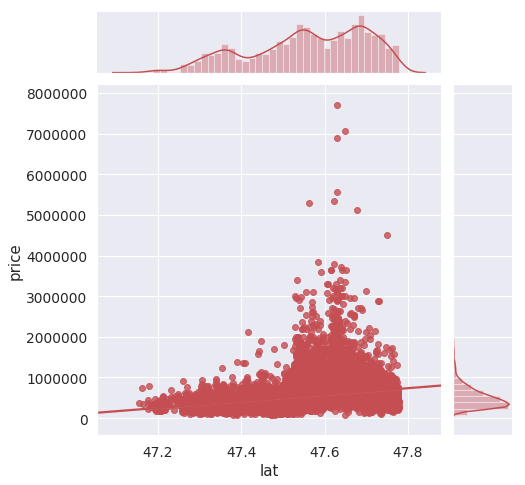

In [25]:
# latitude와 price가 어느정도 상관관계가 있는것으로 나왔다.
sns.jointplot(data=df_train, x='lat', y='price', kind='reg', height=7, color='r')

- 47.5~47.8 : 가격의 변화가 보이는 부분
- 해당 위도의 부분이 번화가? 혹은 중심지?

### 1차 정리
- 'Price'의 값에 log를 취해 정규분포의 형태로 만들어준다. (보다 나은 성능을 위해)
- 여러 이상치들을 볼 수 있었다.
- 선형적인 관계를 보이는것들은 'grade', 'sqft_living' 정도이다.
- **각 column간의 상관관계**가 있을수 있으므로 **partial regression등으로 시각화**도 해봐야할거 같다.
- 추가적인 Feature Extraction과 **비선형관계까지 고려**해봐야할거 같다.

---

### 4. 이외 변수들

##### 시간관련 column : date, yr_built, yr_renovated

In [6]:
train.drop(columns=['id'], inplace=True)
df = train.copy()

In [13]:
df['buy_year'] = df['date'].map(lambda x : int(x.split('T')[0][:4]))
df['buy_month'] = df['date'].map(lambda x : int(x.split('T')[0][4:6]))
df['buy_day'] = df['date'].map(lambda x : int(x.split('T')[0][6:]))

In [15]:
df.drop(columns=['date'], inplace=True)

In [24]:
df[['buy_year', 'buy_month','buy_day', 'price']].corr()

,buy_year,buy_month,buy_day,price
buy_year,1.000000,-0.781074,-0.005003,0.008012
buy_month,-0.781074,1.000000,-0.061457,-0.010352
buy_day,-0.005003,-0.061457,1.000000,-0.013625
price,0.008012,-0.010352,-0.013625,1.000000


- 큰 상관관계를 보이진 않는다.

In [25]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'buy_year', 'buy_month', 'buy_day'],
      dtype='object')

##### View and Condition
- view : 집이 얼마나 좋아보이는지
- condition : 집의 전반적인 상태

In [30]:
df['view'].value_counts() # 1~5까지 맞춰서 condition하고 엮어보자.

0    13548
2      665
3      373
1      241
4      208
Name: view, dtype: int64

In [36]:
df[['view', 'price']].corr()

,view,price
view,1.000000,0.400806
price,0.400806,1.000000


In [31]:
df['condition'].value_counts()

3    9793
4    3956
5    1155
2     110
1      21
Name: condition, dtype: int64

In [37]:
df[['condition', 'price']].corr()

,condition,price
condition,1.00000,0.03974
price,0.03974,1.00000


- 전반적인 상태보다는 겉으로 보기에 얼마나 괜찮은지가 중요해보인다.

##### Zipcode
- 중심지와 교외지역 등을 구분할 수 있지 않을까?

In [35]:
df['zipcode'].value_counts()

98103    421
98038    420
98115    408
98052    408
98117    387
98034    382
98042    372
98118    350
98023    349
98059    345
98133    344
98006    341
98058    306
98155    303
98033    296
98074    295
98125    294
98053    284
98027    275
98056    274
98075    258
98126    251
98106    247
98144    240
98001    239
98092    232
98029    229
98116    226
98065    216
98199    213
        ... 
98008    189
98168    185
98055    185
98003    185
98072    181
98136    179
98112    177
98166    176
98105    174
98177    170
98045    159
98022    159
98077    149
98011    147
98108    136
98002    131
98019    131
98119    127
98005    115
98007    103
98188     91
98014     90
98032     85
98070     79
98109     78
98102     75
98010     63
98024     54
98148     44
98039     36
Name: zipcode, Length: 70, dtype: int64

---

- one-hot 대상들 : 
    - ['yr_built', 'yr_renovated', 'zipcode', 'buy_year', 'buy_month', 'buy_day']
- label-encoding된 상태로 그대로 사용 : 
    - ['grade', 'view', 'condition', 'floor', 'bathrooms', 'bedrooms']

---

### 19.03.20
- 서로 상관관계가 높은 독립변수들
- 변수의 조합을 통한 새로운 변수생성
- outlier의 의미

- 부지면적과 주거면적의 차이와 가격과의 관계는 어떨까? --> **부지면적대비 주거면적의 비율**
- sqft 피트 --> 평 ; 단위 scaling 해보면 어떨까?
- 재건축도 안했는데 `sqft_living15`와 `sqft_living`의 값이 차이나는건 왜일까? 몇개나 되는가?

In [6]:
# 변수 다시 Load
train.drop(columns=['id'], inplace=True)
df = train.copy()

df['buy_year'] = df['date'].map(lambda x : int(x.split('T')[0][:4]))
df['buy_month'] = df['date'].map(lambda x : int(x.split('T')[0][4:6]))
df['buy_day'] = df['date'].map(lambda x : int(x.split('T')[0][6:]))

df.drop(columns=['date'], inplace=True)

df.tail()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,buy_year,buy_month,buy_day
15030,610685.0,4,2.50,2520,6023,2.0,0,0,3,9,...,2014,0,98056,47.5137,-122.167,2520,6023,2014,10,14
15031,1007500.0,4,3.50,3510,7200,2.0,0,0,3,9,...,2009,0,98136,47.5537,-122.398,2050,6200,2015,3,26
15032,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,...,2009,0,98103,47.6993,-122.346,1530,1509,2014,5,21
15033,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,...,2014,0,98146,47.5107,-122.362,1830,7200,2015,2,23
15034,325000.0,2,0.75,1020,1076,2.0,0,0,3,7,...,2008,0,98144,47.5941,-122.299,1020,1357,2014,10,15


In [9]:
df.corr(method='spearman')

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,buy_year,buy_month,buy_day
price,1.000000,0.350185,0.498989,0.646482,0.080554,0.328674,0.113179,0.291720,0.021520,0.662125,...,0.097844,0.112381,-0.009266,0.450692,0.071757,0.573777,0.065771,0.009247,-0.016561,-0.021072
bedrooms,0.350185,1.000000,0.523963,0.649001,0.217457,0.233211,-0.008354,0.079330,0.017853,0.386833,...,0.180364,0.020432,-0.171497,-0.022815,0.195264,0.445933,0.201626,-0.003445,-0.005709,-0.010182
bathrooms,0.498989,0.523963,1.000000,0.748612,0.068576,0.552080,0.058399,0.150776,-0.163990,0.661112,...,0.564570,0.054849,-0.206889,0.000765,0.267203,0.575235,0.062854,-0.020950,0.006675,-0.008071
sqft_living,0.646482,0.649001,0.748612,1.000000,0.307893,0.408417,0.072606,0.227205,-0.059271,0.717800,...,0.352702,0.059647,-0.209218,0.025544,0.292975,0.748214,0.286527,-0.018779,0.006739,-0.006593
sqft_lot,0.080554,0.217457,0.068576,0.307893,1.000000,-0.235869,0.088030,0.118640,0.118165,0.156199,...,-0.039857,0.006904,-0.314217,-0.118702,0.370170,0.360508,0.922681,-0.002423,-0.003301,0.010297
floors,0.328674,0.233211,0.552080,0.408417,-0.235869,1.000000,0.030272,0.020704,-0.285500,0.504506,...,0.552612,0.015442,-0.060686,0.024092,0.148882,0.311335,-0.232303,-0.020448,0.014813,-0.008694
waterfront,0.113179,-0.008354,0.058399,0.072606,0.088030,0.030272,1.000000,0.275925,0.013258,0.065167,...,-0.027922,0.102746,0.027449,-0.020620,-0.034079,0.077448,0.092373,-0.002041,0.006053,0.014859
view,0.291720,0.079330,0.150776,0.227205,0.118640,0.020704,0.275925,1.000000,0.050993,0.211469,...,-0.075096,0.096765,0.082838,-0.002462,-0.100331,0.252132,0.115645,0.019611,-0.018968,0.011505
condition,0.021520,0.017853,-0.163990,-0.059271,0.118165,-0.285500,0.013258,0.050993,1.000000,-0.166075,...,-0.398125,-0.067214,-0.023013,-0.023420,-0.089793,-0.084724,0.118243,-0.040617,0.017469,-0.000448
grade,0.662125,0.386833,0.661112,0.717800,0.156199,0.504506,0.065167,0.211469,-0.166075,1.000000,...,0.494338,0.030901,-0.182848,0.100038,0.227766,0.665039,0.157030,-0.022527,0.009530,-0.020974


- 면적을 나타내는 변수들끼리는 대체로 서로 상관관계가 높다. (sqft류 변수들)
- bathrooms, bedrooms, floor등도 sqft변수들과 관계가 높은데 조금씩 차이가 있다.

In [12]:
df.tail()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,buy_year,buy_month,buy_day
15030,610685.0,4,2.50,2520,6023,2.0,0,0,3,9,...,2014,0,98056,47.5137,-122.167,2520,6023,2014,10,14
15031,1007500.0,4,3.50,3510,7200,2.0,0,0,3,9,...,2009,0,98136,47.5537,-122.398,2050,6200,2015,3,26
15032,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,...,2009,0,98103,47.6993,-122.346,1530,1509,2014,5,21
15033,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,...,2014,0,98146,47.5107,-122.362,1830,7200,2015,2,23
15034,325000.0,2,0.75,1020,1076,2.0,0,0,3,7,...,2008,0,98144,47.5941,-122.299,1020,1357,2014,10,15


- 부지면적과 주거면적의 차이와 가격과의 관계는 어떨까?
- sqft 피트 --> 평 ; 단위 scaling 해보면 어떨까?
- 재건축도 안했는데 `sqft_living15`와 `sqft_living`의 값이 차이나는건 왜일까? 몇개나 되는가?

In [18]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'buy_year', 'buy_month', 'buy_day'],
      dtype='object')

##### 면적을 몇 피트에서 몇 평으로 바꾸자 

In [20]:
# sqft 단위를 평수로 scaling
cols = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15','sqft_lot15']
for col in cols:
    feature_name = "{}_kor".format(col)
    df[feature_name] = df[col] * 0.0281
df.tail()    

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_lot15,buy_year,buy_month,buy_day,sqft_living_kor,sqft_lot_kor,sqft_above_kor,sqft_basement_kor,sqft_living15_kor,sqft_lot15_kor
15030,610685.0,4,2.50,2520,6023,2.0,0,0,3,9,...,6023,2014,10,14,70.812,169.2463,70.812,0.000,70.812,169.2463
15031,1007500.0,4,3.50,3510,7200,2.0,0,0,3,9,...,6200,2015,3,26,98.631,202.3200,73.060,25.571,57.605,174.2200
15032,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,...,1509,2014,5,21,42.993,31.7811,42.993,0.000,42.993,42.4029
15033,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,...,7200,2015,2,23,64.911,163.3453,64.911,0.000,51.423,202.3200
15034,325000.0,2,0.75,1020,1076,2.0,0,0,3,7,...,1357,2014,10,15,28.662,30.2356,28.662,0.000,28.662,38.1317


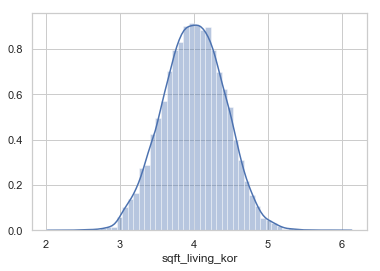

In [24]:
sns.distplot(np.log1p(df['sqft_living_kor']))

In [36]:
sum(df['sqft_living'] != (df['sqft_above'] + df['sqft_basement'])) # 0
# sum(df['sqft_living_kor'] != (df['sqft_above_kor'] + df['sqft_basement_kor'])) # not 0, scaling하면서 오차가 생긴듯하다.

0

- 지하실의 면적도 거주면적에 포함되어있다.
- **거주면적에서 지상(above)와 지하(basement) 각각 차지하는 비중도 관계가 있지 않을까?**

##### 부지면적(sqft_lot) 대비 거주면적(sqft_living) 비율
- 부지면적보다 거주면적이 큰 경우도 있는가? --> 524 case 존재 --> 2층 이상의 집

In [43]:
# 주거면적 > 부지면적 ; aka 1.5층, 2층, 3층, 3.5층 집~
sample_df = df[(df['sqft_living'] / df['sqft_lot']) > 1] 
sample_df[sample_df.floors < 2]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_lot15,buy_year,buy_month,buy_day,sqft_living_kor,sqft_lot_kor,sqft_above_kor,sqft_basement_kor,sqft_living15_kor,sqft_lot15_kor
10987,700000.0,4,1.75,2420,520,1.5,0,0,3,7,...,1170,2014,10,22,68.002,14.6120,68.002,0.0,33.720,32.8770
12452,420000.0,4,1.00,1510,1501,1.5,0,0,3,7,...,1602,2014,10,27,42.431,42.1781,42.431,0.0,43.836,45.0162


- 주거면적 > 부지면적 : 1.5 ~ 3.5 floor를 가진 집
- 이렇게 되면 가격과 뚜렷한 상관성을 보이지 않는 floor를 대체할수 있지 않을까? (floor 버리기 가능할지?)

In [66]:
np.corrcoef(df['price'], (df['sqft_living'] / df['sqft_lot']))

array([[1.        , 0.11947309],
       [0.11947309, 1.        ]])

- 썩....음...관계없나..?!

##### 거주면적(sqft_living) 대비 지상면적(sqft_above) 비율
- sqft_above가 실제 거주하는 면적이지 않나...

In [64]:
np.corrcoef(df['price'], (df['sqft_above'] / df['sqft_living']))

array([[ 1.        , -0.13044771],
       [-0.13044771,  1.        ]])

- 약한건 둘째치고 반비례...?!

##### sqft_living과 sqft_living15 둘이 차이나는 경우
- 15년도 이후에 재건축을 하였다면 둘이 달라질수 있다.
- 하지만, 재건축을 하지않았음에도(yr_renovated == 0), 둘이 차이를 보인다. --> 12666 case
- 전체 데이터의 84%가 이 경우에 해당함. --> 대부분이 15년이후에 리모델링을 했다는 건데 말이 안됨.
- **둘이 차이나는 이유에 대해선 조금 더 고민해봐야할거 같다.**

In [57]:
len(df[df.sqft_living != df.sqft_living15][df.yr_renovated == 0])

12666

- 이런 차이를 보이는게 대부분....

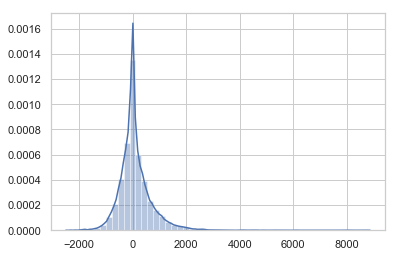

In [56]:
sns.distplot(df['sqft_living'] - df['sqft_living15'])

---

##### zipcode를 자세히보자
- zipcode는 위치정보를 담고있으니.
- 중심지와 외곽지역의 구분이 가능하지 않을까?
- 평당 가격(면적/피트당 가격)과 접목시켜볼 수 있지 않을까?

```
# 평당가격을 구하고
# zipcode별 평당가격을 보자(groupby)
    - 면적을 sqft_living으로 삼을 것이냐, sqft_above로 삼을 것이냐
# 해당 code는 김현우님 kernel참고 (https://www.kaggle.com/chocozzz/house-price-prediction-eda-updated-2019-03-12)

```

In [61]:
df['zipcode'].nunique()

70

In [7]:
df2 = df.copy()

In [8]:
# 평당가격 (실제론 피트당 가격)
# sqft_living
df2['per_price'] = df2['price'] / df2['sqft_living']
price_per_zipcode = df2.groupby(['zipcode'])['per_price'].agg({'zipprice_mean' : 'mean', 'zipprice_std' : np.std}).reset_index()
price_per_zipcode.tail()

,zipcode,zipprice_mean,zipprice_std
65,98177,295.881379,94.260451
66,98178,189.965938,75.193536
67,98188,172.800348,41.900318
68,98198,179.067611,65.707370
69,98199,377.437771,102.337475


In [9]:
price_per_zipcode['zipprice_mean'].describe()

count     70.000000
mean     267.035868
std       91.856639
min      146.575387
25%      192.081079
50%      251.419939
75%      317.146477
max      555.171408
Name: zipprice_mean, dtype: float64

평당가격이 317 이상되면 중심부가 아닐까?

In [10]:
# merge df2 and price_per_zipcode
df2 = df2.merge(price_per_zipcode, how='left', on='zipcode')
df2.tail()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,lat,long,sqft_living15,sqft_lot15,buy_year,buy_month,buy_day,per_price,zipprice_mean,zipprice_std
15030,610685.0,4,2.50,2520,6023,2.0,0,0,3,9,...,47.5137,-122.167,2520,6023,2014,10,14,242.335317,215.244097,64.696581
15031,1007500.0,4,3.50,3510,7200,2.0,0,0,3,9,...,47.5537,-122.398,2050,6200,2015,3,26,287.037037,336.554976,96.875640
15032,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,...,47.6993,-122.346,1530,1509,2014,5,21,235.294118,371.460150,97.427992
15033,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,...,47.5107,-122.362,1830,7200,2015,2,23,173.160173,223.377191,85.597885
15034,325000.0,2,0.75,1020,1076,2.0,0,0,3,7,...,47.5941,-122.299,1020,1357,2014,10,15,318.627451,319.292642,91.391157


In [11]:
df2[df2.zipprice_mean > 317.0].zipcode.unique(), df2[df2.zipprice_mean > 317.0].zipcode.nunique()

(array([98115, 98107, 98103, 98040, 98119, 98112, 98117, 98105, 98122,
        98004, 98136, 98199, 98102, 98033, 98116, 98144, 98109, 98039],
       dtype=int64), 18)

- 18곳

### 19.03.20 정리
- 부지면적(sqft_lot) 대비 거주면적(sqft_living) 비율
    - 부지면적보다 거주면적이 큰 경우도 있는가? --> 524 case 존재 --> 1.5층 이상의 집
    <br><br>
- 거주면적(sqft_living) 대비 지상면적(sqft_above) 비율
    - sqft_above가 실제 거주하는 면적이지 않나...라는 생각에서 출발
    - 이 비율과 price의 상관계수는 -0.13 --> 관계가 없는 것인가....
    <br><br>
- sqft_living과 sqft_living15 둘이 차이나는 경우
    - 15년도 이후에 재건축을 하였다면 둘이 달라질수 있다.
    - 하지만, 재건축을 하지않았음에도(yr_renovated == 0), 둘이 차이를 보인다. --> 12666 case
    - 전체 데이터의 84%가 이 경우에 해당함. 
    <br><br>
- 15년도 주거공간과 현재의 주거공간의 차이로 층수를 늘렸는지 낮췄는지를 알 수 있지 않을까?
    - 15년도 주거공간과 현재의 주거공간의 차이가 리모델링을 의미하는것은 아닐까?
    ```
     - sqft_living > sqft_living15 --> 리모델링해서 층을 높였다.(증축)
     - sqft_living < sqft_living15 --> 층을 줄였다.
     - sqft_living == sqft_living15 --> 유지
    ```
    <br>
- zipcode로 중심지역과 교외/외곽지역을 구분할 수 있지 않을까?
    - 면적당 가격(평당가격)을 구하고
    - 이 가격의 3분위수를 뽑았을때 상위 25%에 드는 곳은 면적당 가격이 317 이상
    - 이에 해당하는 주소지는 18곳 [98115, 98107, 98103, 98040, 98119, 98112, 98117, 98105, 98122,
        98004, 98136, 98199, 98102, 98033, 98116, 98144, 98109, 98039] (18 / 70)

---
---

### 19.03.24
1) zipcode를 가지고 중심지역과 교외지역구분을 좀 더 자세히(시각화)
    - lat 47.5 ~ 47.8사이에서 price가 튀는것과 연관지어보자
<br>

2) 변수간의 상관관계를 다시한번 보도록하자

<br>

3) 새로운 feature를 만들어보자
    - bathrooms, bedrooms를 가지고 알아볼 수 있는 부분 checking
    - 구매시점(date)과 yr_built / yr_renovated 엮어보자
    
<br>
4) regression과 관련된 개념을 정리하자
    - statistics, p-value, t-statistics, F-value, conditional number ....
<br>

5) OLS를 돌려보자!

---

##### Zipcode : 중심지역과 교외지역 자세히
- lat 47.5 ~ 47.8사이에서 price가 튀는것과 연관지어보자

In [23]:
df2.tail()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,lat,long,sqft_living15,sqft_lot15,buy_year,buy_month,buy_day,per_price,zipprice_mean,zipprice_std
15030,610685.0,4,2.50,2520,6023,2.0,0,0,3,9,...,47.5137,-122.167,2520,6023,2014,10,14,242.335317,215.244097,64.696581
15031,1007500.0,4,3.50,3510,7200,2.0,0,0,3,9,...,47.5537,-122.398,2050,6200,2015,3,26,287.037037,336.554976,96.875640
15032,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,...,47.6993,-122.346,1530,1509,2014,5,21,235.294118,371.460150,97.427992
15033,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,...,47.5107,-122.362,1830,7200,2015,2,23,173.160173,223.377191,85.597885
15034,325000.0,2,0.75,1020,1076,2.0,0,0,3,7,...,47.5941,-122.299,1020,1357,2014,10,15,318.627451,319.292642,91.391157


In [12]:
df2[df2.zipprice_mean > 317.0].zipcode.unique(), df2[df2.zipprice_mean > 317.0].zipcode.nunique()

(array([98115, 98107, 98103, 98040, 98119, 98112, 98117, 98105, 98122,
        98004, 98136, 98199, 98102, 98033, 98116, 98144, 98109, 98039],
       dtype=int64), 18)

In [13]:
sample = df2[df2.zipprice_mean > 317.0]
sample.shape[0]

3832

- zipcode별 평균 가격이 317이상인 곳이 3832군데
- 이는 18군데 우편번호로 나뉜다.

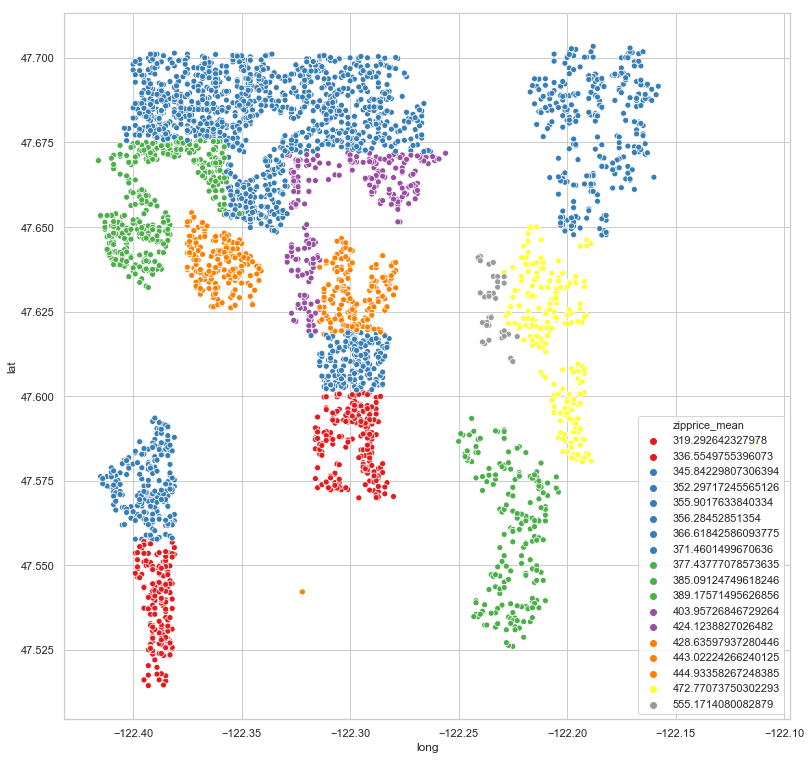

In [49]:
a = sample.loc[(sample.lat < 47.8) & (sample.lat > 47.5), :]
plt.figure(figsize=(13,13))
sns.scatterplot(data=a, x='long', y='lat', hue='zipprice_mean', legend='full', palette='Set1')

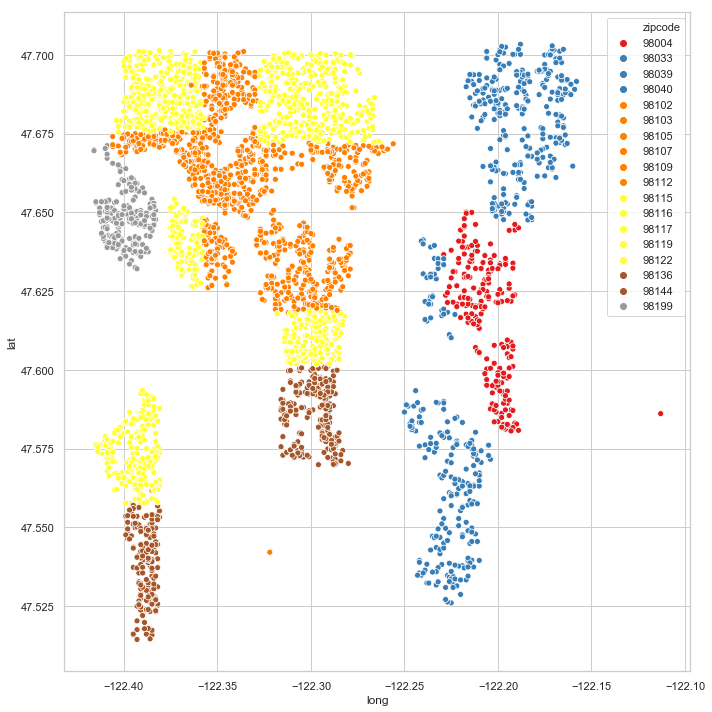

In [48]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=a, x='long', y='lat', hue='zipcode', legend='full', palette='Set1')
plt.tight_layout()

- 상위 25% 집가격을 가진 zipcode 분포
- 대체로 뭉쳐있는거 같긴한데, 아직 이걸가지고 어떻게 써먹을지...떠오르지 않는다.
- **좀 더 생각해보자**

In [33]:
a.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'buy_year', 'buy_month', 'buy_day',
       'per_price', 'zipprice_mean', 'zipprice_std'],
      dtype='object')

In [35]:
np.corrcoef(a['price'], a['sqft_living'])

array([[1.        , 0.84016406],
       [0.84016406, 1.        ]])

In [37]:
np.corrcoef(a['price'], a['sqft_living15'])

array([[1.     , 0.70936],
       [0.70936, 1.     ]])

In [43]:
print(np.corrcoef(a['price'], a['sqft_lot']))
print()
print(np.corrcoef(a['price'], a['sqft_lot15']))

[[1.         0.53680084]
 [0.53680084 1.        ]]

[[1.         0.54664575]
 [0.54664575 1.        ]]


##### feature간 상관관계를 다시한번 보자

In [27]:
df.tail()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,buy_year,buy_month,buy_day
15030,610685.0,4,2.50,2520,6023,2.0,0,0,3,9,...,2014,0,98056,47.5137,-122.167,2520,6023,2014,10,14
15031,1007500.0,4,3.50,3510,7200,2.0,0,0,3,9,...,2009,0,98136,47.5537,-122.398,2050,6200,2015,3,26
15032,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,...,2009,0,98103,47.6993,-122.346,1530,1509,2014,5,21
15033,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,...,2014,0,98146,47.5107,-122.362,1830,7200,2015,2,23
15034,325000.0,2,0.75,1020,1076,2.0,0,0,3,7,...,2008,0,98144,47.5941,-122.299,1020,1357,2014,10,15


In [28]:
df.corr(method='spearman')

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,buy_year,buy_month,buy_day
price,1.000000,0.350185,0.498989,0.646482,0.080554,0.328674,0.113179,0.291720,0.021520,0.662125,...,0.097844,0.112381,-0.009266,0.450692,0.071757,0.573777,0.065771,0.009247,-0.016561,-0.021072
bedrooms,0.350185,1.000000,0.523963,0.649001,0.217457,0.233211,-0.008354,0.079330,0.017853,0.386833,...,0.180364,0.020432,-0.171497,-0.022815,0.195264,0.445933,0.201626,-0.003445,-0.005709,-0.010182
bathrooms,0.498989,0.523963,1.000000,0.748612,0.068576,0.552080,0.058399,0.150776,-0.163990,0.661112,...,0.564570,0.054849,-0.206889,0.000765,0.267203,0.575235,0.062854,-0.020950,0.006675,-0.008071
sqft_living,0.646482,0.649001,0.748612,1.000000,0.307893,0.408417,0.072606,0.227205,-0.059271,0.717800,...,0.352702,0.059647,-0.209218,0.025544,0.292975,0.748214,0.286527,-0.018779,0.006739,-0.006593
sqft_lot,0.080554,0.217457,0.068576,0.307893,1.000000,-0.235869,0.088030,0.118640,0.118165,0.156199,...,-0.039857,0.006904,-0.314217,-0.118702,0.370170,0.360508,0.922681,-0.002423,-0.003301,0.010297
floors,0.328674,0.233211,0.552080,0.408417,-0.235869,1.000000,0.030272,0.020704,-0.285500,0.504506,...,0.552612,0.015442,-0.060686,0.024092,0.148882,0.311335,-0.232303,-0.020448,0.014813,-0.008694
waterfront,0.113179,-0.008354,0.058399,0.072606,0.088030,0.030272,1.000000,0.275925,0.013258,0.065167,...,-0.027922,0.102746,0.027449,-0.020620,-0.034079,0.077448,0.092373,-0.002041,0.006053,0.014859
view,0.291720,0.079330,0.150776,0.227205,0.118640,0.020704,0.275925,1.000000,0.050993,0.211469,...,-0.075096,0.096765,0.082838,-0.002462,-0.100331,0.252132,0.115645,0.019611,-0.018968,0.011505
condition,0.021520,0.017853,-0.163990,-0.059271,0.118165,-0.285500,0.013258,0.050993,1.000000,-0.166075,...,-0.398125,-0.067214,-0.023013,-0.023420,-0.089793,-0.084724,0.118243,-0.040617,0.017469,-0.000448
grade,0.662125,0.386833,0.661112,0.717800,0.156199,0.504506,0.065167,0.211469,-0.166075,1.000000,...,0.494338,0.030901,-0.182848,0.100038,0.227766,0.665039,0.157030,-0.022527,0.009530,-0.020974


---

##### bedrooms와 bathrooms
- bathrooms대비 bedrooms의 비율과 price와의 상관정도는 얼마나 될까?

In [55]:
np.corrcoef(df['price'], (df['bedrooms'] / (df['bedrooms'] + df['bathrooms'])))

array([[ 1., nan],
       [nan, nan]])

In [56]:
np.corrcoef(df['price'],  (df['bedrooms'] + df['bathrooms']))

array([[1.        , 0.47552609],
       [0.47552609, 1.        ]])

In [53]:
df[df.bedrooms == 0]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,buy_year,buy_month,buy_day
6885,235000.0,0,0.00,1470,4800,2.0,0,0,3,7,...,1996,0,98065,47.5265,-121.828,1060,7200,2014,12,23
8826,320000.0,0,2.50,1490,7111,2.0,0,0,3,7,...,1999,0,98065,47.5261,-121.826,1500,4675,2015,2,18
12781,265000.0,0,0.75,384,213444,1.0,0,0,3,4,...,2003,0,98070,47.4177,-122.491,1920,224341,2014,10,29
13522,142000.0,0,0.00,290,20875,1.0,0,0,1,1,...,1963,0,98024,47.5308,-121.888,1620,22850,2014,9,26


- bedrooms가 0인 곳도 있네...
- 이건 뭐하는 곳일까...
- 주거면적은 잡혀있는데...침실이 없다?

---

##### 구매시점(date)과 yr_built / yr_renovated 엮어보자

In [62]:
renovated_y = df[df.yr_renovated != 0]
renovated_n = df[df.yr_renovated == 0]

print(np.corrcoef(df.loc[df.yr_renovated != 0, 'price'], renovated_y['sqft_living']))
print()
print(np.corrcoef(df.loc[df.yr_renovated == 0, 'price'], renovated_n['sqft_living']))

[[1.        0.7942836]
 [0.7942836 1.       ]]

[[1.        0.6981285]
 [0.6981285 1.       ]]
